### Experiment-4
#### Implementing a 2 layer Neural Network with engineered features (Word2Vec word vectors)

In [98]:
# Imports
import pandas as pd
import numpy as np
import nltk

# Plotting
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

# Neural Network
from neural_net import TwoLayerNet

def rel_error(x, y):
    """ returns relative error """
    return np.max(np.abs(x - y) / (np.maximum(1e-8, np.abs(x) + np.abs(y))))

In [99]:
# Read training and testing data
train = pd.read_csv('data/train.csv') # category, text
test = pd.read_csv('data/test.csv') # category, text

# Replace NaN with ''
train = train.fillna('')
test = test.fillna('')

In [100]:
# Imports
from nltk.tokenize import RegexpTokenizer

# Function to clean text
def clean_text_w2v(text):
    '''
    Function to clean text and modify string
    Process: decode > lowercase >  tokenize 
        Input: text string
        Output: cleaned and modified text string
    '''
    # Decode: utf-8
    text = text.decode('utf8')
    # RegExp tokenizer
    tokenizer = RegexpTokenizer(r'\w+')
    # Convert text to lower case
    raw_text = text.lower()
    # Tokenize
    tokens = tokenizer.tokenize(raw_text)    
    return tokens

In [101]:
# Clean the training and testing texts
train_clean_X = []
for i in xrange(train.shape[0]):
    temp = train['text'].ix[i]
    train_clean_X.append(clean_text_w2v(temp))
    
test_clean_X = []
for i in xrange(test.shape[0]):
    temp = test['text'].ix[i]
    test_clean_X.append(clean_text_w2v(temp))
    
print test_clean_X[:5]

[[u'i', u'love', u'listing', u'rap', u'music'], [u'back', u'on', u'water', u'meditation'], [u'me', u'the', u'first', u'time', u'i', u'ever', u'pinned', u'someone', u'in', u'a', u'cradle', u'proud', u'of', u'myself', u'and', u'how', u'far', u'i', u've', u'gone', u'since', u'then', u'even', u'girls', u'can', u'be', u'just', u'as', u'strong', u'as', u'boys'], [u'any', u'single', u'ladies', u'from', u'circleville', u'on', u'here', u'22m'], [u'i', u'want', u'to', u'go', u'down', u'on', u'a', u'girl', u'so', u'bad', u'been', u'so', u'long', u'lethbridge']]


In [102]:
# Get maximum length of texts in training data
max_len = max(len(x) for x in train_clean_X)
print 'Maximum length of texts in training data: ', max_len

# Function to pad text
def pad_sentences(sentences, max_len = max_len, padding_word="<PAD/>"):
    """
    Pads all sentences to the same length. The length is defined by the longest sentence.
    Returns padded sentences.
    """
    sequence_length = max_len
    padded_sentences = []
    for i in xrange(len(sentences)):
        sentence = sentences[i]
        num_padding = sequence_length - len(sentence)
        new_sentence = sentence + [padding_word] * num_padding
        padded_sentences.append(new_sentence)
    return padded_sentences

Maximum length of texts in training data:  66


In [103]:
# Pad training and testing data
train_X_padded = pad_sentences(train_clean_X, padding_word="<PAD/>")
test_X_padded = pad_sentences(test_clean_X, padding_word="<PAD/>")

In [104]:
# Multiprocessing
from multiprocessing import cpu_count

# Gensim
from gensim.models.word2vec import Word2Vec

In [105]:
# Model: 
#       size = 100 as per http://arxiv.org/pdf/1408.5882v2.pdf
#       window = 5 max distance between the current and predicted word within a sentence.
#       min_count` = 10 (ignore all words with total frequency lower than this.)

# Initiate model
num_features = 100
model = Word2Vec(size=num_features, window=5, min_count=5, workers=cpu_count())

# Build vocabulary 
model.build_vocab(train_X_padded)

# Train using training data and save model
model.train(train_X_padded)
model.save('w2v/train_pad')

# Feature vector of each word in vocabulary
print "Vocabulary: {} words".format(model.syn0.shape[0])
print "Word Vector length (# of features): ", model.syn0.shape[1]

Vocabulary: 2537 words
Word Vector length (# of features):  100


In [106]:
# Function to create data for Neural Network
def create_text_vector(text, model, size):
    # Get model vocabulary
    VOCAB = model.vocab.keys()
    vec = np.zeros(size).reshape((1, size))
    for word in text:
        if word in VOCAB: # word in vocabulary
            temp = model[word].reshape((1, size))
        else: # unknown word
            temp = np.random.uniform(-0.25,0.25, size)   
        # stack word vecs
        vec = np.vstack([vec, temp])
    # Flatten word vectors    
    vec_flat = vec.flatten()
    return vec_flat

train_array = []
for text in train_X_padded:
    text_vec = create_text_vector(text, model, num_features)
    train_array.append(text_vec)

In [107]:
# Train using testing data and save model
model.train(test_X_padded)
model.save('w2v/test_pad')

test_array = []
for text in test_X_padded:
    text_vec = create_text_vector(text, model, num_features)
    test_array.append(text_vec)

In [108]:
# NN input data for training and desting
train_mtx = np.vstack(train_array)
print 'Train dim: ', train_mtx.shape

test_mtx = np.vstack(test_array)
print 'Test dim: ', test_mtx.shape

Train dim:  (14048, 6700)
Test dim:  (3599, 6700)


In [109]:
# Data Preparation

# Label encoding: y
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
le.fit(train['category'])
print 'Number of classes: ', len(list(le.classes_))
y_train = le.transform(train['category'])
y_test = le.transform(test['category'])

# X
X_train = train_mtx
X_test = test_mtx

# Create a validation set: 1000 data points
num_training = train_mtx.shape[0] - 1000
num_validation = 1000
mask = range(num_training, num_training + num_validation)
X_val = X_train[mask]
y_val = y_train[mask]

mask = range(num_training)
X_train = X_train[mask]
y_train = y_train[mask]

print 'Train data shape: ', X_train.shape
print 'Train labels shape: ', y_train.shape
print 'Validation data shape: ', X_val.shape
print 'Validation labels shape: ', y_val.shape
print 'Test data shape: ', X_test.shape
print 'Test labels shape: ', y_test.shape

Number of classes:  17
Train data shape:  (13048, 6700)
Train labels shape:  (13048,)
Validation data shape:  (1000, 6700)
Validation labels shape:  (1000,)
Test data shape:  (3599, 6700)
Test labels shape:  (3599,)


#### Train the network
- SGD with momentum 
- Adjust the learning rate with an exponential learning rate schedule as optimization proceeds; after each epoch, reduce the learning rate by multiplying it by a decay rate.

In [111]:
input_size = X_train.shape[1]
hidden_size = 1000
num_classes = 17
net = TwoLayerNet(input_size, hidden_size, num_classes)

# Train the network
stats = net.train(X_train, y_train, X_val, y_val,
            num_iters=1000, batch_size=100,
            learning_rate=1e-4, learning_rate_decay=0.95,
            reg=0.5, verbose=True)

# Predict on the validation set
val_acc = (net.predict(X_val) == y_val).mean()
print 'Validation accuracy: ', val_acc

iteration 0 / 1000: loss 2.850022
iteration 100 / 1000: loss 2.848931
iteration 200 / 1000: loss 2.847690
iteration 300 / 1000: loss 2.846296
iteration 400 / 1000: loss 2.845666
iteration 500 / 1000: loss 2.845224
iteration 600 / 1000: loss 2.844883
iteration 700 / 1000: loss 2.842609
iteration 800 / 1000: loss 2.841791
iteration 900 / 1000: loss 2.840737
Validation accuracy:  0.239


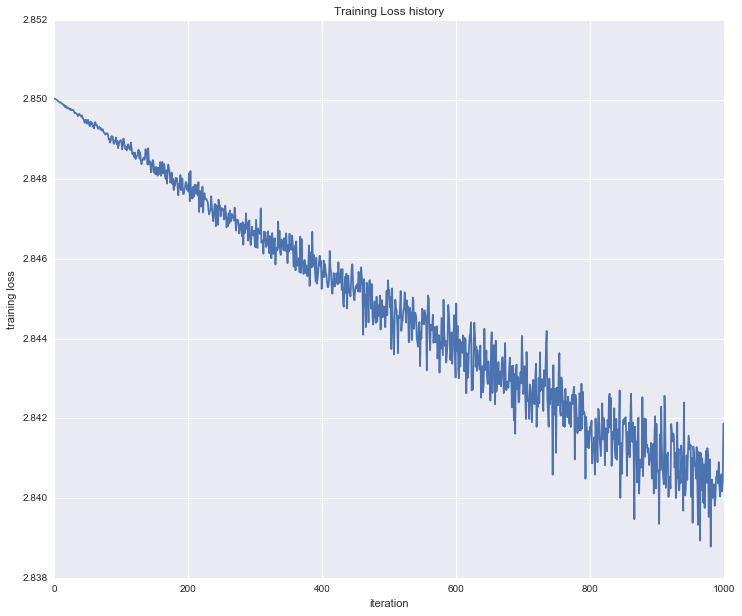

Final training loss:  2.84186882294


In [113]:
# plot the loss history
plt.figure(figsize = (12, 10))
plt.plot(stats['loss_history'])
plt.xlabel('iteration')
plt.ylabel('training loss')
plt.title('Training Loss history')
plt.show()
print 'Final training loss: ', stats['loss_history'][-1]

In [115]:
from sklearn.metrics import f1_score
predicted = net.predict(X_val)
val_f1_macro = f1_score(y_val, predicted, average='macro')
print 'F1 Score (macro): {}'.format(val_f1_macro)

F1 Score (macro): 0.022693823292


### Debug the training
With the default parameters we provided above, you should get a validation accuracy of about 0.023 and F1 macro score of about 0.022 on the validation set. This isn't very good.

One strategy for getting insight into what's wrong is to plot the loss function and the accuracies on the training and validation sets during optimization.

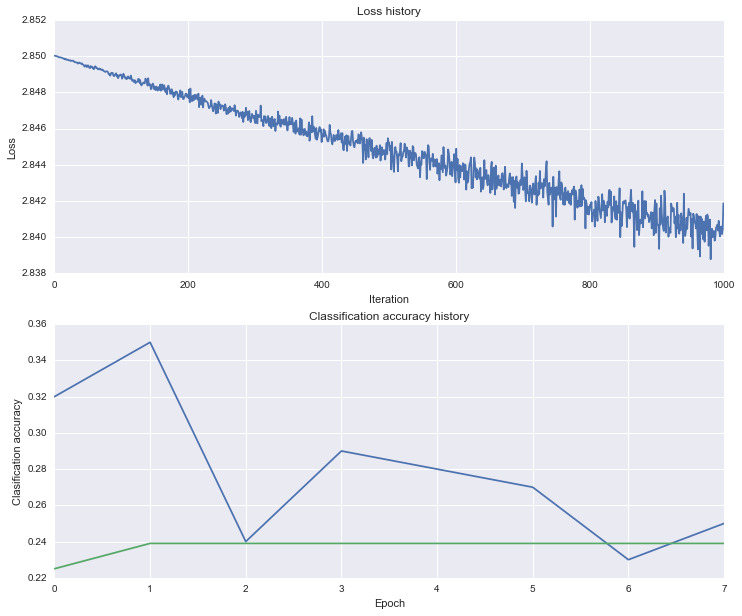

In [116]:
# Plot the loss function and train / validation accuracies
plt.figure(figsize = (12, 10))
plt.subplot(2, 1, 1)
plt.plot(stats['loss_history'])
plt.title('Loss history')
plt.xlabel('Iteration')
plt.ylabel('Loss')

plt.subplot(2, 1, 2)
plt.plot(stats['train_acc_history'], label='train')
plt.plot(stats['val_acc_history'], label='val')
plt.title('Classification accuracy history')
plt.xlabel('Epoch')
plt.ylabel('Clasification accuracy')
plt.show()

### Tuning hyperparameters (Takes a long time!) - Around 7 hrs on 16GB MacBook Pro

Looking at the visualizations above, we see that the loss is decreasing more or less linearly, which seems to suggest that the learning rate may be too low.

In [133]:
best_net = None # store the best model into this 

#################################################################################
# TODO: Tune hyperparameters using the validation set. Store your best trained  #
# model in best_net.                                                            #
#                                                                               #
# To help debug your network, it may help to use visualizations similar to the  #
# ones we used above; these visualizations will have significant qualitative    #
# differences from the ones we saw above for the poorly tuned network.          #
#                                                                               #
# Tweaking hyperparameters by hand can be fun, but you might find it useful to  #
# write code to sweep through possible combinations of hyperparameters          #
# automatically like we did on the previous exercises.                          #
#################################################################################
#pass
# Generate hyperparameters randomly
def random_hyperparams():
    # Lambda function to select hyperparameter randomly
    random = lambda x: np.random.choice(x, 1)[0]
    # Hyperparameter values
    hyperparams = {
        'hidden_size': np.array([250, 500, 750]),
        'batch_size': np.arange(100, 1000, 350),
        'learning_rate': 10.0**np.arange(0, 3),
        'learning_rate_decay': np.array([0.75, 1.25]),
        'reg': 5.0**np.arange(-2,2,1)
    }
    temp = {hyperparam: random(values) for hyperparam, values in hyperparams.iteritems()}
    return temp


best_val = -1   
best_hyperparams = None

for i in xrange(100):
    # Randomly generate hyperparameters
    params = random_hyperparams()
    
    # Neural Network
    input_size = X_train.shape[1]
    hidden_size = params['hidden_size']
    num_classes = 17
    net = TwoLayerNet(input_size, hidden_size, num_classes)

    # Train the network
    stats = net.train(X_train, y_train, X_val, y_val, num_iters=1000, 
                      batch_size=params['batch_size'],
                      learning_rate=params['learning_rate'], 
                      learning_rate_decay=params['learning_rate_decay'],
                      reg=params['reg'], verbose=False)

    # Predict on the validation set
    val_acc = (net.predict(X_val) == y_val).mean()
    print 'Validation accuracy: ', val_acc
    # Best accuracy, network and parameters
    if val_acc > best_val:
        best_val = val_acc
        best_net = net
        best_hyperparams = params
        print 'Best accuracy (after {} iterations) is {}%'.format(i, best_val*100)

#################################################################################
#                               END OF YOUR CODE                                #
#################################################################################

Validation accuracy:  0.009
Best accuracy (after 0 iterations) is 0.9%
Validation accuracy:  0.239
Best accuracy (after 1 iterations) is 23.9%
Validation accuracy:  0.009
Validation accuracy:  0.009
Validation accuracy:  0.009
Validation accuracy:  0.239
Validation accuracy:  0.172
Validation accuracy:  0.239
Validation accuracy:  0.239
Validation accuracy:  0.009
Validation accuracy:  0.009
Validation accuracy:  0.009
Validation accuracy:  0.009
Validation accuracy:  0.239
Validation accuracy:  0.009
Validation accuracy:  0.239
Validation accuracy:  0.009
Validation accuracy:  0.354
Best accuracy (after 17 iterations) is 35.4%
Validation accuracy:  0.009
Validation accuracy:  0.41
Best accuracy (after 19 iterations) is 41.0%
Validation accuracy:  0.009
Validation accuracy:  0.009
Validation accuracy:  0.462
Best accuracy (after 22 iterations) is 46.2%
Validation accuracy:  0.009
Validation accuracy:  0.457
Validation accuracy:  0.009
Validation accuracy:  0.172
Validation accuracy:  0

### Run on the test set

In [134]:
test_acc = (best_net.predict(X_test) == y_test).mean()
print 'Test accuracy: ', test_acc
predicted = best_net.predict(X_test)
test_f1_macro = f1_score(y_test, predicted, average='macro')
print 'F1 Score (macro): {}'.format(test_f1_macro)

Test accuracy:  0.47151986663
F1 Score (macro): 0.105455174349


#### Improve accuracy by optimizing hyperparameters

In [142]:
def optimize_hyperparam(hyperparam_name, best_hyperparams):
    '''
    hyperparam_name: string
    best_hyperparams: dict
    '''
    
    # Hyperparameter values
    params = {
        'hidden_size': np.array([250, 500, 750]),
        'batch_size': np.arange(100, 1000, 350),
        'learning_rate': 10.0**np.arange(0, 3),
        'learning_rate_decay': np.array([0.75, 1.25]),
        'reg': 5.0**np.arange(-2,2,1)
    }
    
    # Create copy of best hyperparameters
    hyperparams = best_hyperparams.copy()
    # accuracy
    accuracy = []
    
    for hyperparam_value in params[hyperparam_name]:
        
        # Change hyperparameter value iteratively (sensitivity analysis)
        hyperparams[hyperparam_name] = hyperparam_value
        
        # Neural Network
        input_size = X_train.shape[1]
        num_classes = 17
        hidden_size = hyperparams['hidden_size']
        net = TwoLayerNet(input_size, hidden_size, num_classes)
        
        # Train the network
        stats = net.train(X_train, y_train, X_val, y_val, num_iters=1000, 
                      batch_size=hyperparams['batch_size'],
                      learning_rate=hyperparams['learning_rate'], 
                      learning_rate_decay=hyperparams['learning_rate_decay'],
                      reg=hyperparams['reg'], verbose=False)
        
        # Predict on the validation set
        val_acc = (net.predict(X_val) == y_val).mean()
        # Validataion accuracy
        accuracy.append(val_acc)
    
    # Plot of accuracy
    plt.figure(figsize = (12, 10))
    plt.plot(params[hyperparam_name], accuracy)
    plt.title('Varying hyperparameter: ' + hyperparam_name)
    plt.xlabel(hyperparam_name)
    plt.ylabel('Accuracy')
    
    return params[hyperparam_name]

array([100, 450, 800])

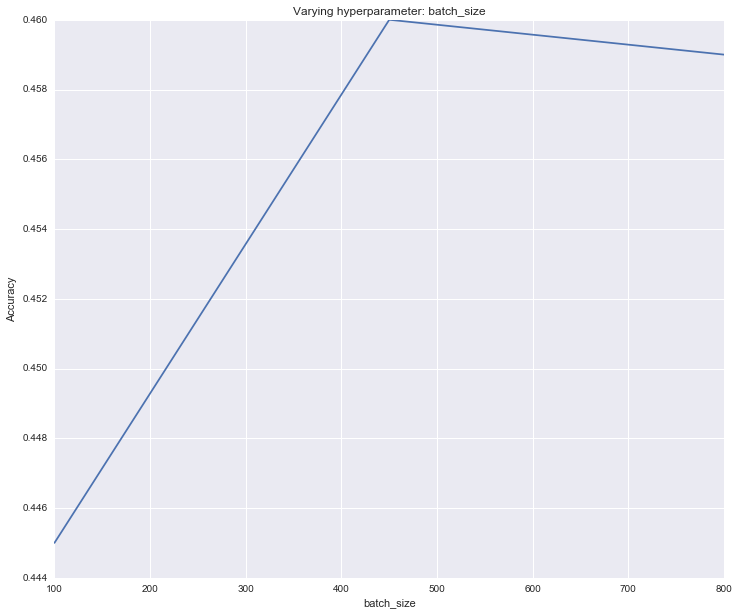

In [143]:
# Optimize: batch_size
optimize_hyperparam('batch_size', best_hyperparams)

In [95]:
# Set best batch_size based on above pic
best_hyperparams['batch_size'] = 450

#### Similarly optimize other hyperparameters. Then train the model with optimized hyperparameters and make predictions on testing data